In [114]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

In [115]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=-1) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Creating placeholder lists
    X, Y = [], []

    for i in range(len(ts) - lag - n_ahead):
        Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
        # X.append(ts[i:(i + lag)])

    ts = np.delete(ts, -1, axis=1)
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            X.append(ts[i:(i + lag)])

    X = np.array(X)
    Y = np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [116]:
df2005 = pd.read_csv("../data/forModels/clean_data_2005.csv", sep = ',')
df2005.index = pd.to_datetime(df2005.Date, format="%d.%m.%Y")
df2005 = df2005.drop(['Date'], axis=1)

df2006 = pd.read_csv("../data/forModels/clean_data_2006.csv", sep = ',')
df2006.index = pd.to_datetime(df2006.Date, format="%d.%m.%Y")
df2006 = df2006.drop(['Date'], axis=1)

print(f'Shape of data 2005: {df2005.shape}')
print(f'Shape of data 2006: {df2006.shape}')

df = pd.concat([df2005, df2006], axis=0)
# df = df.fillna(0)

Shape of data 2005: (165, 5)
Shape of data 2006: (165, 5)


In [117]:
print(f"Total unique dates in the dataset: {len(set(df.index))}")

Total unique dates in the dataset: 330


In [118]:
print(f"Number of rows in the dataset: {df.shape[0]}")

Number of rows in the dataset: 330


In [119]:
df.describe()

,Avg,DD,DDSum,Rain,Sum_trap
count,330.000000,330.000000,330.000000,330.000000,330.000000
mean,15.800455,5.965576,535.756061,2.186970,7.989394
std,4.360108,4.076186,352.729278,6.334408,11.495832
min,4.150000,0.000000,32.130000,0.000000,0.000000
25%,12.682500,2.682500,163.335000,0.000000,1.000000
50%,15.795000,5.795000,542.510000,0.000000,4.000000
75%,18.507500,8.507500,861.680000,1.000000,10.875000
max,26.580000,16.580000,1152.970000,79.300000,92.000000


In [120]:
# Share of obs in testing 
test_share = 0.12

# The features used in the modeling 
# features_final = ['Avg', 'Dev', 'Rain', 'DD', 'DD Sum', 'CountTrap1', 'CountTrap2', 'CountTrap3', 'Sum']
features_final = ['Avg', 'DD', 'DDSum', 'Rain', 'Sum_trap']

In [146]:
# Subseting only the needed columns 
ts = df[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[int(nrows * (test_share)):int(nrows)]
test = ts[0:int(nrows * (test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])
ts_s

,Avg,DD,DDSum,Rain,Sum_trap
Date,,,,,
2005-06-09,-1.534739,-1.593760,-1.318729,-0.327214,-0.681133
2005-06-10,-1.128250,-1.179935,-1.313776,-0.327214,-0.637387
2005-06-11,-1.113558,-1.164795,-1.308641,-0.327214,-0.681133
2005-06-12,-1.385367,-1.444884,-1.306889,-0.327214,-0.724878
2005-06-13,-0.273643,-0.299296,-1.291394,-0.327214,-0.462407
...,...,...,...,...,...
2005-06-04,0.223449,0.212939,-1.337486,-0.019310,-0.112445
2005-06-05,-0.457298,-0.488545,-1.324257,1.828113,-0.287426
2005-06-06,-1.138045,-1.190028,-1.319424,-0.096286,-0.462407


In [148]:
# Number of lags to use for models
lag = 15
# Steps ahead to forecast 
n_ahead = 5

X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [149]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [150]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (272, 15, 4)
Shape of the target data: (272, 5)
Shape of validation data: (38, 15, 4)
Shape of the validation target data: (38, 5)


In [151]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [152]:
# Epochs for training
epochs = 200
# Batch size 
batch_size = 32
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 9

model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [153]:
model.model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 15, 4)]           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 9)                 504       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 50        
Total params: 554
Trainable params: 554
Non-trainable params: 0
_________________________________________________________________


In [154]:
history = model.train()

Epoch 1/200
9/9 [==============================] - 0s 19ms/step - loss: 0.6564 - val_loss: 0.7935
Epoch 2/200
9/9 [==============================] - 0s 4ms/step - loss: 0.6465 - val_loss: 0.7808
Epoch 3/200
9/9 [==============================] - 0s 4ms/step - loss: 0.6385 - val_loss: 0.7734
Epoch 4/200
9/9 [==============================] - 0s 4ms/step - loss: 0.6314 - val_loss: 0.7671
Epoch 5/200
9/9 [==============================] - 0s 4ms/step - loss: 0.6245 - val_loss: 0.7593
Epoch 6/200
9/9 [==============================] - 0s 4ms/step - loss: 0.6180 - val_loss: 0.7505
Epoch 7/200
9/9 [==============================] - 0s 5ms/step - loss: 0.6115 - val_loss: 0.7414
Epoch 8/200
9/9 [==============================] - 0s 5ms/step - loss: 0.6048 - val_loss: 0.7318
Epoch 9/200
9/9 [==============================] - 0s 4ms/step - loss: 0.5977 - val_loss: 0.7216
Epoch 10/200
9/9 [==============================] - 0s 5ms/step - loss: 0.5904 - val_loss: 0.7109
Epoch 11/200
9/9 [==========

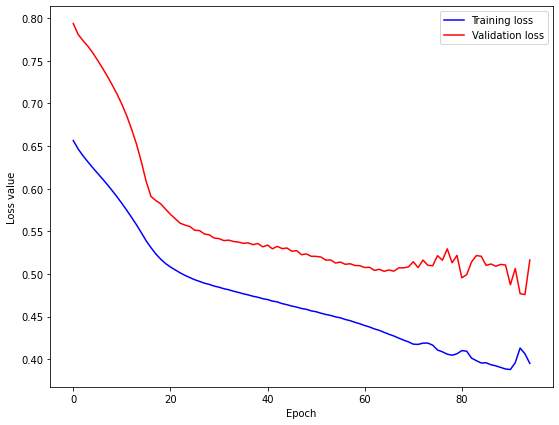

In [155]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [156]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

In [157]:
# # Comparing the forecasts with the actual values
# yhat = [x[0] for x in model.predict(Xtrain)]
# y = [y[0] for y in Ytrain]

In [158]:
# Creating the frame to store both predictions
days = df.index.values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'Count': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'Count': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['Count_absolute'] = [(x * train_std['Sum_trap']) + train_mean['Sum_trap'] for x in frame['Count']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['Count_absolute_original'] - pivoted['Count_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [159]:
pivoted.head(20)

,Count_forecast,Count_original,Count_absolute_forecast,Count_absolute_original,res,res_abs
day,,,,,,
2006-09-05,-0.922329,-0.724878,-2.256832,0.0,2.256832,2.256832
2006-09-06,-0.963454,-0.724878,-2.726884,0.0,2.726884,2.726884
2006-09-07,-0.983336,-0.724878,-2.954133,0.0,2.954133,2.954133
2006-09-08,-1.025549,-0.724878,-3.436613,0.0,3.436613,3.436613
2006-09-09,-1.046979,-0.724878,-3.681559,0.0,3.681559,3.681559
2006-09-10,-0.975175,-0.724878,-2.860856,0.0,2.860856,2.860856
2006-09-11,-0.976957,-0.724878,-2.881215,0.0,2.881215,2.881215
2006-09-12,-0.896502,-0.724878,-1.961635,0.0,1.961635,1.961635
2006-09-13,-0.816133,-0.724878,-1.043033,0.0,1.043033,1.043033


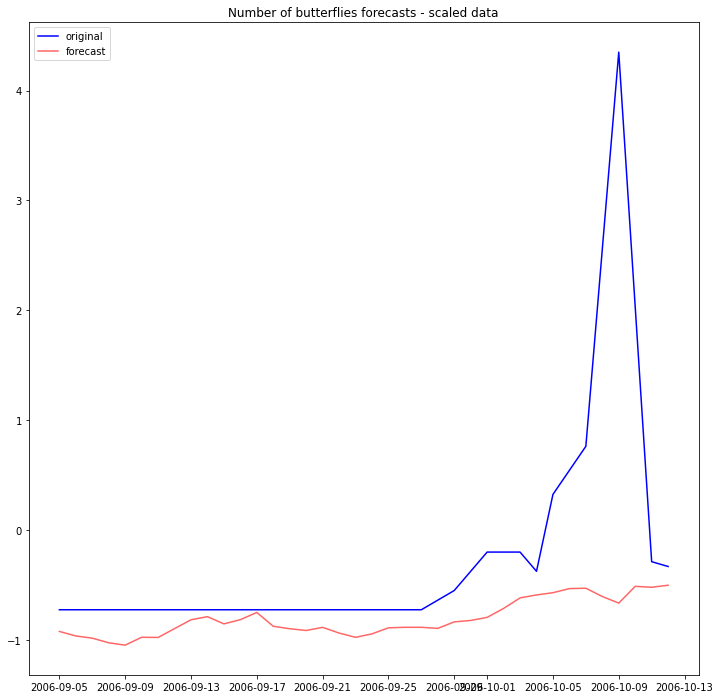

In [160]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.Count_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.Count_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Number of butterflies forecasts - scaled data')
plt.legend()
plt.show()

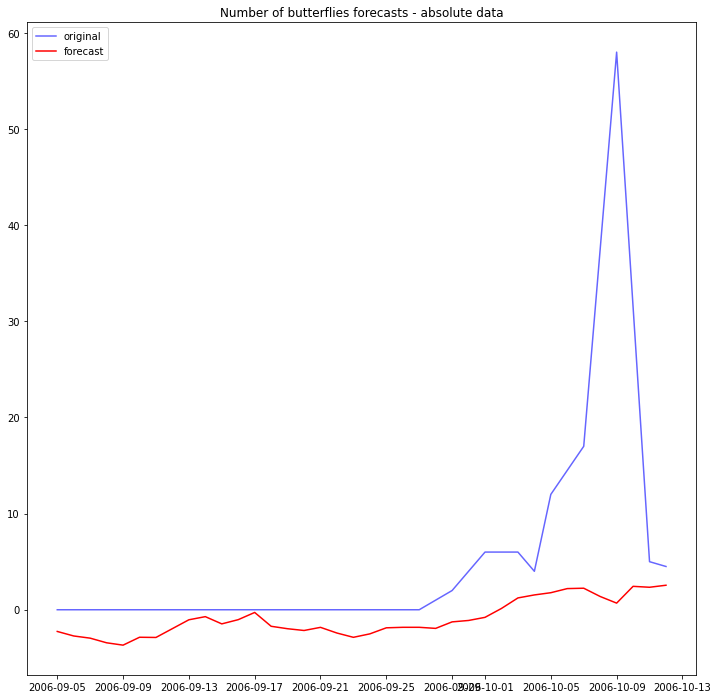

In [161]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.Count_absolute_original, color='blue', label='original', alpha=0.6)
plt.plot(pivoted.index, pivoted.Count_absolute_forecast, color='red', label='forecast')
plt.title('Number of butterflies forecasts - absolute data')
plt.legend()
plt.show()

In [162]:
# How it fit to train data
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xtrain)]
y = [y[0] for y in Ytrain]

In [163]:
# Creating the frame to store both predictions
days = df.index.values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'Count': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'Count': yhat, 'type': 'forecast'})
])

# Creating the unscaled values column
frame['Count_absolute'] = [(x * train_std['Sum_trap']) + train_mean['Sum_trap'] for x in frame['Count']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['Count_absolute_original'] - pivoted['Count_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

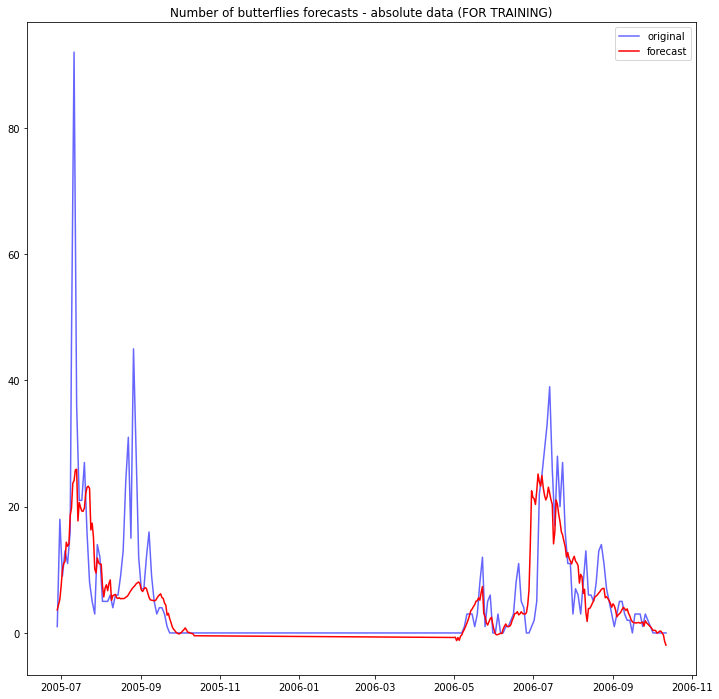

In [164]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.Count_absolute_original, color='blue', label='original', alpha=0.6)
plt.plot(pivoted.index, pivoted.Count_absolute_forecast, color='red', label='forecast')
plt.title('Number of butterflies forecasts - absolute data (FOR TRAINING)')
plt.legend()
plt.show()